In [1]:
import pandas as pd
import geopandas as gpd
import ee
from simpledbf import Dbf5
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import json
import scipy.stats as stats
from mwqm.utils import gdf_to_fc, retrieve
from collections import Counter
import scipy
from scipy.stats import norm
import cartopy.crs as ccrs
import cartopy.feature as cfeature


ID_COL = 'huc12'
GEO_CRS = 'EPSG:4326'
PROJ_CRS = 'EPSG:3857'
VISUALS_DIR = Path("visuals")
DATA_DIR = Path("data")
GEE_DIR = DATA_DIR / "gee"
PROJECT_NAME = "motives-wq"
RESPONSE_COL = 'tnKgKm2'

ee.Initialize(project=PROJECT_NAME)

nitrogen_dbf_path = DATA_DIR / "wang-2024/other_formats/nonpoint_source_watershed_nitrogen_yield.dbf"
wbd_path = DATA_DIR / "wbdhu12_a_us_september2024.gdb"
wbd_snapshot_path = DATA_DIR / "NHDPlusNationalData/WBDSnapshot_National.shp"


PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


### Load DBF file

In [2]:
# Load in per-HUC data on nitrogen yield in KG / KM2 / YR
dbf = Dbf5(nitrogen_dbf_path)
df = dbf.to_dataframe()


print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for HUC12 ID integrity
print("\nChecking HUC12 ID integrity...")
df[ID_COL] = df[ID_COL].astype(str)

incorrect_length = df[df[ID_COL].str.len() != 12]
print(f"Found {len(incorrect_length)} HUC IDs with incorrect length (should be 12 digits)")

print(f"Shape of df: {df.shape}")

Dataset shape: (66694, 2)

Column names:
['huc12', 'tnKgKm2']

First 5 rows of the dataset:
          huc12      tnKgKm2
0  010802030501   422.156388
1  010900010402  -403.803571
2  010900010202   231.523120
3  010900010602   526.272211
4  010900040802 -4771.533755

Checking HUC12 ID integrity...
Found 0 HUC IDs with incorrect length (should be 12 digits)
Shape of df: (66694, 2)


/tmp/ipykernel_39573/347842005.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([plot['transform'](x) for x in axes[i].get_xticks()])
/tmp/ipykernel_39573/347842005.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([plot['transform'](x) for x in axes[i].get_xticks()])


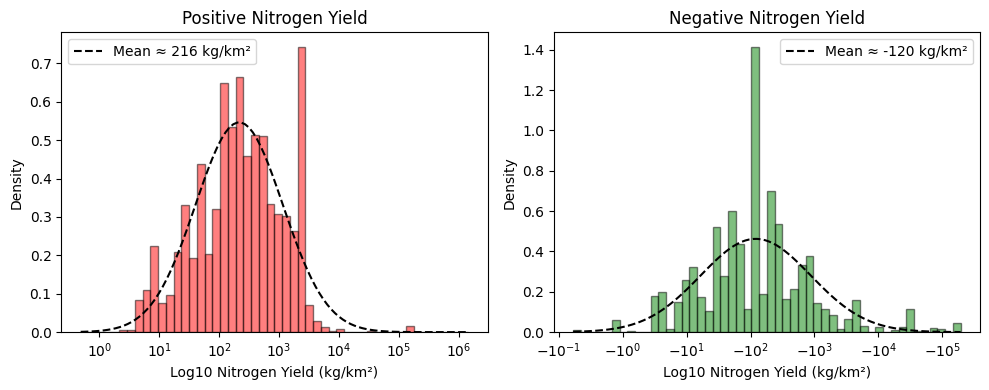

In [3]:
# Note some of the yields are negative, some are positive
# but they are still much more easily visualized using log scale
is_pos = df[RESPONSE_COL] > 0
is_neg = df[RESPONSE_COL] < 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Create a list of data and settings for each subplot
plots = [
    {'data': np.log10(df.loc[is_pos, RESPONSE_COL]), 'color': 'r', 'title': 'Positive Nitrogen Yield', 'transform': lambda x: f"$10^{{{int(x)}}}$", 'sign': 1},
    {'data': np.log10(-df.loc[is_neg, RESPONSE_COL]), 'color': 'g', 'title': 'Negative Nitrogen Yield', 'transform': lambda x: f"$-10^{{{int(x)}}}$", 'sign': -1}
]

# Loop through each subplot
for i, plot in enumerate(plots):
    data = plot['data']
    mean, std = norm.fit(data)
    
    # Convert log10 mean to natural units for legend
    natural_mean = plot['sign'] * (10**mean)
    
    # Create histogram
    axes[i].hist(data, bins=50, alpha=0.5, color=plot['color'], edgecolor='black', density=True)
    
    # Plot normal distribution fit
    x = np.linspace(data.min(), data.max(), 100)
    pdf = norm.pdf(x, mean, std)
    axes[i].plot(x, pdf, 'k--', label=f'Mean ≈ {natural_mean:.0f} kg/km²')
    
    # Set labels and formatting
    axes[i].set_title(plot['title'])
    axes[i].set_ylabel("Density")
    axes[i].set_xlabel("Log10 Nitrogen Yield (kg/km²)")
    axes[i].set_xticklabels([plot['transform'](x) for x in axes[i].get_xticks()])
    axes[i].legend()

plt.tight_layout()
plt.savefig(VISUALS_DIR / "nitrogen_yield_histogram.png", dpi=300)


In [4]:
# Get the row with the maximum nitrogen yield
max_nitrogen_yield = df.loc[df[RESPONSE_COL].idxmax()]
print(f"Maximum nitrogen yield: {max_nitrogen_yield}")

Maximum nitrogen yield: huc12        071401010303
tnKgKm2    1445019.811577
Name: 18444, dtype: object


### Count HUCs by level

In [5]:
# Create columns huc 2, huc 4, huc 8, etc by taking first 2, 4, 8, etc. characters of huc12

assert np.all(df.huc12.str.len() == 12), "Not all HUC12 IDs are 12 characters long"
for i in [2, 4, 8]:
    df[f'huc{i}'] = df[ID_COL].str[:i]
    # Count # of unique values in each column
    n_unique = df[f'huc{i}'].nunique()
    print(f"Number of unique values in huc{i}: {n_unique}")

    # Create int-valued column starting from 0 and contiguous
    df['huc{i}_int'] = df[f'huc{i}'].astype('category').cat.codes

huc_cols = [f'huc{i}' for i in [2, 4, 8]]


Number of unique values in huc2: 18
Number of unique values in huc4: 196
Number of unique values in huc8: 1730


### Merge on WBD data

In [6]:
wbd_gdf = gpd.read_file(wbd_path, layer="WBDHU12")
print(f"Loaded {len(wbd_gdf)} watersheds from the WBD dataset with { wbd_gdf.huc12.nunique()} unique HUC12 IDs")

merged_gdf = (
    pd.merge(df, wbd_gdf, on="huc12", how="inner")
    .pipe(gpd.GeoDataFrame, geometry="geometry", crs=GEO_CRS)
    .assign(
        proj_geometry=lambda gdf: gdf.to_crs(PROJ_CRS).geometry,
        area_km2=lambda gdf: gdf.proj_geometry.area / 10**6,
        perimeter_km=lambda gdf: gdf.proj_geometry.length / 10**3,
        area_1000_km2=lambda gdf: gdf["area_km2"] / 1000,
        perimeter_1000_km=lambda gdf: gdf["perimeter_km"] / 1000,
        area_perimeter_squared_ratio=lambda gdf: gdf["area_km2"] / (gdf["perimeter_km"] ** 2),
        latitude=lambda gdf: gdf.geometry.centroid.y,
        longitude=lambda gdf: gdf.geometry.centroid.x,
    )
    .drop(columns=["proj_geometry"]) # Don't need the projected geometry anymore
)

print(f"After merging on HUC12, the dataset has {len(merged_gdf)} rows")

/mnt/m2ssd/data/Dropbox/research/motives/motives-wq-modeling/.venv/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts.  The processing may be really slow.  You can skip the processing by setting METHOD=SKIP.
  return ogr_read(


Loaded 103025 watersheds from the WBD dataset with 103025 unique HUC12 IDs


/tmp/ipykernel_39573/3957327449.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude=lambda gdf: gdf.geometry.centroid.y,
/tmp/ipykernel_39573/3957327449.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude=lambda gdf: gdf.geometry.centroid.x,


After merging on HUC12, the dataset has 66694 rows


In [7]:
PLOT_OUTLIERS = False

if PLOT_OUTLIERS:
  
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    cutoff = 10 ** 4
    # Filter the geometries in the extreme 1% quantile
    extreme_geometries = merged_gdf[np.abs(merged_gdf[RESPONSE_COL]) > cutoff]

    projection = ccrs.PlateCarree()

    fig, ax = plt.subplots(figsize=(24, 16), subplot_kw={'projection': projection})

    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
    ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=0.3)
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', alpha=0.3)

    merged_gdf.plot(ax=ax, color='lightgray', edgecolor='gray', alpha=0.5, transform=ccrs.PlateCarree())

    extreme_geometries.plot(ax=ax, column=RESPONSE_COL, legend=True, cmap='coolwarm', transform=ccrs.PlateCarree())

    # Set the title and show the plot
    plt.title(f"Catchments with |{RESPONSE_COL}| > {cutoff}")
    plt.show()

#### Filter out catchments with large values

In [8]:
cutoff = 10**4
is_too_big = np.abs(merged_gdf[RESPONSE_COL]) > cutoff

merged_gdf = merged_gdf.loc[~is_too_big]

print(f"Found {is_too_big.sum()} rows with nitrogen yield greater than {cutoff} kg/km^2")
print(f"Out of {len(merged_gdf)} total rows, {is_too_big.mean() * 100:.2f}% of the dataset were removed")

Found 674 rows with nitrogen yield greater than 10000 kg/km^2
Out of 66020 total rows, 1.01% of the dataset were removed


In the above cell, we've removed catchments with no neighbors. The variable `hucs_with_adj` labels the rows and columns of `adj_matrix`. 

### Summary statistics and visualizations for N yield data

#### Correlation plot for yield against watershed size
This test and plot is a check to make sure the data isn't randomly permuted and does show a statistically significant trend of some type.

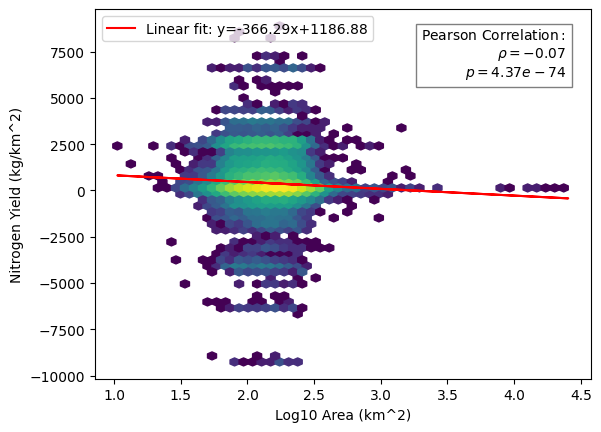

In [9]:
# Calculate the correlation coefficient and p-value
log_area = np.log10(merged_gdf.area_km2)
nitrogen_yield = merged_gdf[RESPONSE_COL]
correlation, p_value = stats.pearsonr(log_area, nitrogen_yield)

# Fit a linear regression model
slope, intercept = np.polyfit(log_area, nitrogen_yield, 1)
regression_line = slope * log_area + intercept

# Plot the hexbin
plt.hexbin(log_area, nitrogen_yield, gridsize=50, bins='log')
plt.xlabel("Log10 Area (km^2)")
plt.ylabel("Nitrogen Yield (kg/km^2)")

# Plot the regression line
plt.plot(log_area, regression_line, color='red', label=f'Linear fit: y={slope:.2f}x+{intercept:.2f}')

# Add the correlation statistics to the plot with LaTeX and fancy symbols
plt.text(0.95, 0.95, f'$\\mathrm{{Pearson\\ Correlation:}}$\n$\\rho = {correlation:.2f}$\n$p = {p_value:.2e}$', 
         ha='right', va='top', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.show()

#### Spatial plot of log10 yield


In [10]:
# this plot uses the log10(abs value) of the nitrogen yield. Locations with negative
# yield are marked blue, positive yield are marked red
MAKE_SPATIAL_PLOT = False
if MAKE_SPATIAL_PLOT:
    merged_gdf['log_nitrogen_yield'] = np.log10(np.abs(merged_gdf[RESPONSE_COL]))
    merged_gdf['color'] = np.where(merged_gdf[RESPONSE_COL] > 0, 'red', 'blue')

    fig, ax = plt.subplots(figsize=(12, 8))

    merged_gdf.loc[merged_gdf.color == 'red'].plot(ax=ax, column='log_nitrogen_yield', legend=True, cmap='Reds', label='Positive Yield')
    merged_gdf.loc[merged_gdf.color == 'blue'].plot(ax=ax, column='log_nitrogen_yield', legend=True, cmap='Blues', label='Negative Yield')

    plt.legend()
    plt.show()


### Download data from GEE

#### Define tasks

In [11]:
SIMPLIFY_GEOMETRIES = True
SIMPLIFY_METERS = 500

tasks = [
    {
        'image_id':"USGS/NLCD_RELEASES/2019_REL/NLCD/2001",
        "band": "landcover",
        "label": "landcover_nlcd",
        "is_group": True,
        "stat": "PERCENTAGE"
    },
    {
        'image': ee.ImageCollection("USDA/NASS/CDL").filterDate("2005-01-01", "2006-01-01").first(),
        'band': 'cropland',
        'label': 'cropland_cdl',
        "is_group": True,
        "stat": "PERCENTAGE"
    },
    {
        'image':ee.Image("CGIAR/SRTM90_V4").divide(1000.),
        'band': 'elevation',
        'label':'elevation_km_srtm',
        'stat': 'mean'
    },
    {
        'image_id':"CSP/ERGo/1_0/Global/ALOS_topoDiversity",
        'band':'constant',
        'label':'topo_diversity_alos',
        'stat': 'mean'
    },
    {
        'image_id':"JAXA/ALOS/PALSAR/YEARLY/FNF4/2017",
        'band':'fnf',
        'label':'forest_jaxa',
        "is_group": True,
        "stat": "PERCENTAGE"
    },
    {
        'image': ee.Image('WORLDCLIM/V1/MONTHLY/12').multiply(12. / 1000.),
        'band':'prec',
        'label':'annual_precip_m',
        'stat': 'mean'
    },
    {
        'image': ee.Terrain.slope(ee.Image("USGS/SRTMGL1_003")),
        'label':'slope_srtm',
        'stat': 'mean',
        'band':'slope'
    },
    {
        "image_id": "CSP/ERGo/1_0/US/lithology",
        "label": "lithology",
        "stat": "PERCENTAGE",
        "band": "b1",
        "is_group": True
    },
    {
        "image": ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density").first().select('population_density').multiply(1. / 1000.),
        "label": "average_population_2000",
        "stat": "mean",
        "band": "population_density"
    },
]


#### Run GEE tasks

In [12]:
LOAD_DATA_FROM_DISK = False

if LOAD_DATA_FROM_DISK:
    final_gdf = gpd.read_file("data/merged_gdf.gpkg")
    print(f"Loaded data from disk with shape: {final_gdf.shape}")
else:
    batch_size  = 2000
    num_batches = int(np.ceil(len(merged_gdf) / batch_size))

    all_batches = []

    print(f"Download data from Earth Engine across {num_batches} batches")

    for i in range(num_batches):
        gdf_batch = merged_gdf.iloc[i * batch_size:(i + 1) * batch_size].copy()

        fc = None

        for task in tasks:
            task_file = GEE_DIR / f"gee-{task['label']}-{i+1}.parquet"
            if not os.path.exists(task_file):

                if fc is None:
                    if SIMPLIFY_GEOMETRIES:
                        # Get the total number of vertices in the dataset
                        total_vertices = gdf_batch["geometry"].apply(lambda x: x.wkt.count(",") + 1).sum()
                        print(f"Total vertices in batch {i+1}: {total_vertices}")
                        gdf_batch["geometry"] = gdf_batch["geometry"].to_crs(PROJ_CRS).simplify(SIMPLIFY_METERS).to_crs(GEO_CRS)
                        print(f"Total vertices in simplified batch {i+1}: {gdf_batch['geometry'].apply(lambda x: x.wkt.count(',') + 1).sum()}")
                    fc = gdf_to_fc(gdf_batch[[ID_COL, "geometry"]])

                task_df = retrieve(fc, task)
                task_df[ID_COL] = task_df[ID_COL].astype(str).str.zfill(12)
                task_df.to_parquet(task_file)
                print(f"Saved task {task['label']} for batch {i+1} to {task_file}")
            else:
                task_df = pd.read_parquet(task_file)
                print(f"Loaded task {task['label']} for batch {i+1} from {task_file}")

            gdf_batch = pd.merge(gdf_batch, task_df, on=ID_COL)

        all_batches.append(gdf_batch)

    # Vertically concatenate all batches and get extra
    # geographic features
    final_gdf = pd.concat(all_batches, ignore_index=True)
    final_gdf.to_file("data/merged_gdf.gpkg", driver="GPKG")
    final_gdf.set_index(ID_COL, inplace=True)
    final_gdf.head()

name_mapping_pretty = {
    "annual_precip_m_mean": "Annual Precipitation (m)",
    "area_1000_km2": "Area (1000 km^2)",
    "area_perimeter_squared_ratio": "Area/Perimeter^2",
    "average_population_2000_mean": "Average Population Density (2000)",
    "elevation_km_srtm_mean": "Elevation (km)",
    "forest_jaxa_Class_1": "Dense Forest (%)",
    "forest_jaxa_Class_2": "Non-dense Forest (%)",
    "forest_jaxa_Class_3": "Non-forest (%)",
    "forest_jaxa_Class_4": "Water (%)",
    "glacial_till_coarse": "Glacial Till Coarse (%)",
    "glacial_till_loam": "Glacial Till Loam (%)",
    "landcover_nlcd_Class_11": "Open Water (%)",
    "landcover_nlcd_Class_12": "Perennial Ice/Snow (%)",
    "landcover_nlcd_Class_21": "Developed, Open Space (%)",
    "landcover_nlcd_Class_22": "Developed, Low Intensity (%)",
    "landcover_nlcd_Class_23": "Developed, Medium Intensity (%)",
    "landcover_nlcd_Class_24": "Developed, High Intensity (%)",
    "landcover_nlcd_Class_31": "Barren Land (%)",
    "landcover_nlcd_Class_41": "Deciduous Forest (%)",
    "landcover_nlcd_Class_42": "Evergreen Forest (%)",
    "landcover_nlcd_Class_43": "Mixed Forest (%)",
    "landcover_nlcd_Class_52": "Shrub/Scrub (%)",
    "landcover_nlcd_Class_71": "Grassland/Herbaceous (%)",
    "landcover_nlcd_Class_81": "Pasture/Hay (%)",
    "landcover_nlcd_Class_82": "Cultivated Crops (%)",
    "landcover_nlcd_Class_90": "Woody Wetlands (%)",
    "landcover_nlcd_Class_95": "Emergent Herbaceous Wetlands (%)",
    "lithology_Class_1": "Carbonate (%)",
    "lithology_Class_3": "Non-carbonate (%)",
    "lithology_Class_4": "Alkaline intrusive (%)",
    "lithology_Class_5": "Silicic residual (%)",
    "lithology_Class_7": "Extrusive volcanic (%)",
    "lithology_Class_8": "Colluvial sediment (%)",
    "lithology_Class_9": "Glacial till clay (%)",
    "lithology_Class_10": "Glacial till loam (%)",
    "lithology_Class_11": "Glacial till coarse (%)",
    "lithology_Class_13": "Glacial lake sediment fine (%)",
    "lithology_Class_14": "Glacial outwash coarse (%)",
    "lithology_Class_15": "Hydric (%)",
    "lithology_Class_16": "Eolian sediment coarse (%)",
    "lithology_Class_17": "Eolian sediment fine (%)",
    "lithology_Class_18": "Saline lake sediment (%)",
    "lithology_Class_19": "Alluvium and coastal sediment fine (%)",
    "lithology_Class_20": "Coastal sediment coarse (%)",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "perimeter_1000_km": "Perimeter (1000 km)",
    "slope_srtm_mean": "Slope",
    "topo_diversity_alos_mean": "Topographic Diversity",
    "cropland_cdl_Class_1": "Corn (%)",
    "cropland_cdl_Class_2": "Cotton (%)",
    "cropland_cdl_Class_3": "Rice (%)",
    #"cropland_cdl_Class_4": "Sorghum (%)",
    "cropland_cdl_Class_5": "Soybeans (%)",
    "cropland_cdl_Class_6": "Sunflower (%)",
    "cropland_cdl_Class_10": "Peanuts (%)",
    "cropland_cdl_Class_11": "Tobacco (%)",
    "cropland_cdl_Class_12": "Sweet Corn (%)",
    "cropland_cdl_Class_13": "Pop or Ornamental Corn (%)",
    #"cropland_cdl_Class_14": "Mint (%)",
    #"cropland_cdl_Class_21": "Barley (%)",
    "cropland_cdl_Class_22": "Durum Wheat (%)",
    "cropland_cdl_Class_23": "Spring Wheat (%)",
    "cropland_cdl_Class_24": "Winter Wheat (%)",
    "cropland_cdl_Class_25": "Other Small Grains (%)",
    "cropland_cdl_Class_26": "Double Crop Winter Wheat/Soybeans (%)",
    "cropland_cdl_Class_27": "Rye (%)",
    "cropland_cdl_Class_28": "Oats (%)",
    #"cropland_cdl_Class_29": "Millet (%)",
    #"cropland_cdl_Class_30": "Speltz (%)",
    "cropland_cdl_Class_31": "Canola (%)",
    "cropland_cdl_Class_32": "Flaxseed (%)",
    #"cropland_cdl_Class_33": "Safflower (%)",
    #"cropland_cdl_Class_34": "Brassica napus (%)",
    #"cropland_cdl_Class_35": "Mustard (%)",
    "cropland_cdl_Class_36": "Alfalfa (%)",
    #"cropland_cdl_Class_37": "Other Hay/Non-Alfalfa (%)",
    #"cropland_cdl_Class_38": "Camelina (%)",
    "cropland_cdl_Class_39": "Buckwheat (%)",
    "cropland_cdl_Class_41": "Sugarbeets (%)",
    "cropland_cdl_Class_42": "Dry Beans (%)",
    "cropland_cdl_Class_43": "Potatoes (%)",
    "cropland_cdl_Class_44": "Other Crops (%)",
    #"cropland_cdl_Class_45": "Sugarcane (%)",
    "cropland_cdl_Class_46": "Sweet Potatoes (%)",
    #"cropland_cdl_Class_47": "Misc Vegetables & Fruits (%)",
    "cropland_cdl_Class_48": "Watermelons (%)",
    "cropland_cdl_Class_49": "Onions (%)",
    "cropland_cdl_Class_50": "Cucumbers (%)",
    "cropland_cdl_Class_51": "Chickpeas (%)",
    "cropland_cdl_Class_52": "Lentils (%)",
    "cropland_cdl_Class_53": "Peas (%)",
    "cropland_cdl_Class_54": "Tomatoes (%)",
    "cropland_cdl_Class_55": "Caneberries (%)",
    "cropland_cdl_Class_56": "Hops (%)",
    "cropland_cdl_Class_57": "Herbs (%)",
    "cropland_cdl_Class_58": "Clover/Wildflowers (%)",
    "cropland_cdl_Class_59": "Sod/Grass Seed (%)",
    "cropland_cdl_Class_60": "Switchgrass (%)",
    "cropland_cdl_Class_61": "Fallow/Idle Cropland (%)",
    "cropland_cdl_Class_66": "Cherries (%)",
    "cropland_cdl_Class_67": "Peaches (%)",
    "cropland_cdl_Class_68": "Apples (%)",
    "cropland_cdl_Class_69": "Grapes (%)",
    "cropland_cdl_Class_70": "Christmas Trees (%)",
    "cropland_cdl_Class_71": "Other Tree Crops (%)",
    "cropland_cdl_Class_72": "Citrus (%)",
    "cropland_cdl_Class_74": "Pecans (%)",
    "cropland_cdl_Class_75": "Almonds (%)",
    "cropland_cdl_Class_76": "Walnuts (%)",
    "cropland_cdl_Class_77": "Pears (%)",
    "cropland_cdl_Class_92": "Aquaculture (%)",
    "cropland_cdl_Class_204": "Pistachios (%)",
    "cropland_cdl_Class_205": "Triticale (%)",
    "cropland_cdl_Class_206": "Carrots (%)",
    "cropland_cdl_Class_207": "Asparagus (%)",
    "cropland_cdl_Class_208": "Garlic (%)",
    "cropland_cdl_Class_209": "Cantaloupes (%)",
    "cropland_cdl_Class_210": "Prunes (%)",
    "cropland_cdl_Class_211": "Olives (%)",
    "cropland_cdl_Class_212": "Oranges (%)",
    "cropland_cdl_Class_213": "Honeydew Melons (%)",
    "cropland_cdl_Class_214": "Broccoli (%)",
    "cropland_cdl_Class_215": "Avocados (%)",
    "cropland_cdl_Class_216": "Peppers (%)",
    "cropland_cdl_Class_217": "Pomegranates (%)",
    "cropland_cdl_Class_218": "Nectarines (%)",
    "cropland_cdl_Class_219": "Greens (%)",
    "cropland_cdl_Class_220": "Plums (%)",
    "cropland_cdl_Class_221": "Strawberries (%)",
    "cropland_cdl_Class_222": "Squash (%)",
    "cropland_cdl_Class_223": "Apricots (%)",
    "cropland_cdl_Class_224": "Vetch (%)",
    #"cropland_cdl_Class_225": "Double Crop Winter Wheat/Corn (%)",
    #"cropland_cdl_Class_226": "Double Crop Oats/Corn (%)",
    "cropland_cdl_Class_227": "Lettuce (%)",
    #"cropland_cdl_Class_228": "Double Crop Triticale/Corn (%)",
    "cropland_cdl_Class_229": "Pumpkins (%)",
    #"cropland_cdl_Class_230": "Double Crop Lettuce/Durum Wheat (%)",
    #"cropland_cdl_Class_231": "Double Crop Lettuce/Cantaloupe (%)",
    #"cropland_cdl_Class_232": "Double Crop Lettuce/Cotton (%)",
    #"cropland_cdl_Class_233": "Double Crop Lettuce/Barley (%)",
    #"cropland_cdl_Class_234": "Double Crop Durum Wheat/Sorghum (%)",
    #"cropland_cdl_Class_235": "Double Crop Barley/Sorghum (%)",
    #"cropland_cdl_Class_236": "Double Crop Winter Wheat/Sorghum (%)",
    #"cropland_cdl_Class_237": "Double Crop Barley/Corn (%)",
    #"cropland_cdl_Class_238": "Double Crop Winter Wheat/Cotton (%)",
    #"cropland_cdl_Class_239": "Double Crop Soybeans/Cotton (%)",
    #"cropland_cdl_Class_240": "Double Crop Soybeans/Oats (%)",
    "cropland_cdl_Class_241": "Double Crop Corn/Soybeans (%)",
    "cropland_cdl_Class_242": "Blueberries (%)",
    "cropland_cdl_Class_243": "Cabbage (%)",
    "cropland_cdl_Class_244": "Cauliflower (%)",
    "cropland_cdl_Class_245": "Celery (%)",
    "cropland_cdl_Class_246": "Radishes (%)",
    "cropland_cdl_Class_247": "Turnips (%)",
    "cropland_cdl_Class_248": "Eggplants (%)",
    "cropland_cdl_Class_249": "Gourds (%)",
    "cropland_cdl_Class_250": "Cranberries (%)",
    #"cropland_cdl_Class_254": "Double Crop Barley/Soybeans (%)"
}

# Since the water class is captured from multiple data products,
# we'll drop all but one of them
redundant_classes_drop = [
    'landcover_nlcd_Class_sum',
    'forest_jaxa_Class_4',
    'lithology_Class_0',
    'forest_jaxa_Class_3',
    'forest_jaxa_Class_1',
    'forest_jaxa_Class_2',
    "average_population_2000_mean",
    "landcover_nlcd_Class_82",
    "landcover_nlcd_Class_81",
    "cropland_cdl_Class_sum",
    "cropland_cdl_Class_61",    # Fallow/Idle Cropland
    "cropland_cdl_Class_62",    # Pasture/Grass
    "cropland_cdl_Class_63",    # Forest
    "cropland_cdl_Class_64",    # Shrubland
    "cropland_cdl_Class_65",    # Barren
    "cropland_cdl_Class_81",    # Clouds/No Data
    "cropland_cdl_Class_82",    # Developed
    "cropland_cdl_Class_83",    # Water
    "cropland_cdl_Class_87",    # Wetlands
    "cropland_cdl_Class_88",    # Nonag/Undefined
    "cropland_cdl_Class_92",    # Aquaculture
    "cropland_cdl_Class_111",   # Open Water
    "cropland_cdl_Class_112",   # Perennial Ice/Snow
    "cropland_cdl_Class_121",   # Developed/Open Space
    "cropland_cdl_Class_122",   # Developed/Low Intensity
    "cropland_cdl_Class_123",   # Developed/Med Intensity
    "cropland_cdl_Class_124",   # Developed/High Intensity
    "cropland_cdl_Class_131",   # Barren
    "cropland_cdl_Class_141",   # Deciduous Forest
    "cropland_cdl_Class_142",   # Evergreen Forest
    "cropland_cdl_Class_143",   # Mixed Forest
    "cropland_cdl_Class_152",   # Shrubland
    "cropland_cdl_Class_176",   # Grassland/Pasture
    "cropland_cdl_Class_190",   # Woody Wetlands
    "cropland_cdl_Class_195"    # Herbaceous Wetlands
    
]

# Check to make sure all the mapped pretty column names are unique
names_with_dups = Counter(name_mapping_pretty.values())
dups = {k: v for k, v in names_with_dups.items() if v > 1}
if dups:
    print(f"Duplicate pretty column names found: {dups}")

# Report on how many columns to be dropped are actually present
print(f"Out of {len(redundant_classes_drop)} columns to be dropped, {len(set(redundant_classes_drop) & set(final_gdf.columns))} are present")
    
final_gdf = final_gdf.drop(redundant_classes_drop, axis=1, errors='ignore') \
    .rename(columns=name_mapping_pretty)


Download data from Earth Engine across 34 batches
Loaded task landcover_nlcd for batch 1 from data/gee/gee-landcover_nlcd-1.parquet
Loaded task cropland_cdl for batch 1 from data/gee/gee-cropland_cdl-1.parquet
Loaded task elevation_km_srtm for batch 1 from data/gee/gee-elevation_km_srtm-1.parquet
Loaded task topo_diversity_alos for batch 1 from data/gee/gee-topo_diversity_alos-1.parquet
Loaded task forest_jaxa for batch 1 from data/gee/gee-forest_jaxa-1.parquet
Loaded task annual_precip_m for batch 1 from data/gee/gee-annual_precip_m-1.parquet
Loaded task slope_srtm for batch 1 from data/gee/gee-slope_srtm-1.parquet
Loaded task lithology for batch 1 from data/gee/gee-lithology-1.parquet
Loaded task average_population_2000 for batch 1 from data/gee/gee-average_population_2000-1.parquet
Loaded task landcover_nlcd for batch 2 from data/gee/gee-landcover_nlcd-2.parquet
Loaded task cropland_cdl for batch 2 from data/gee/gee-cropland_cdl-2.parquet
Loaded task elevation_km_srtm for batch 2 fr

### Prepare dataframe for modeling

In [13]:
ADD_INDICATOR_COLS = True
ADD_INTERACTION_COLS = True

predictor_cols = name_mapping_pretty.values()

interaction_pairs = [
 ['Annual Precipitation (m)', 'Elevation (km)'],
 ['Annual Precipitation (m)', 'Evergreen Forest (%)'],
 ['Annual Precipitation (m)', 'Deciduous Forest (%)'],
 ['Annual Precipitation (m)', 'Soybeans (%)'],
 ['Annual Precipitation (m)', 'Mixed Forest (%)'],
 ['Annual Precipitation (m)', 'Slope'],
 ['Elevation (km)', 'Slope'],
 ['Annual Precipitation (m)', 'Colluvial sediment (%)'],
 ['Annual Precipitation (m)', 'Other Small Grains (%)'],
 ['Annual Precipitation (m)', 'Shrub/Scrub (%)'],
 ['Annual Precipitation (m)', 'Glacial outwash coarse (%)'],
 ['Annual Precipitation (m)', 'Corn (%)'],
 ['Annual Precipitation (m)', 'Glacial till loam (%)'],
 ['Annual Precipitation (m)', 'Area/Perimeter^2'],
 ['Elevation (km)', 'Evergreen Forest (%)'],
 ['Elevation (km)', 'Mixed Forest (%)'],
 ['Annual Precipitation (m)', 'Grassland/Herbaceous (%)'],
 ['Elevation (km)', 'Grassland/Herbaceous (%)'],
 ['Deciduous Forest (%)', 'Elevation (km)'],
 ['Annual Precipitation (m)', 'Glacial till clay (%)'],
 ['Elevation (km)', 'Woody Wetlands (%)'],
 ['Annual Precipitation (m)', 'Developed, Open Space (%)'],
 ['Elevation (km)', 'Shrub/Scrub (%)'],
 ['Slope', 'Soybeans (%)'],
 ['Annual Precipitation (m)', 'Area (1000 km^2)'],
 ['Annual Precipitation (m)', 'Developed, Low Intensity (%)'],
 ['Corn (%)', 'Elevation (km)'],
 ['Alluvium and coastal sediment fine (%)', 'Annual Precipitation (m)'],
 ['Developed, Low Intensity (%)', 'Elevation (km)'],
 ['Annual Precipitation (m)', 'Silicic residual (%)']
]

response_col = "tnKgKm2"
predictor_cols = [col for col in predictor_cols if col in final_gdf.columns]

# Perform feature engineering; this cell should be idempotent
# and can be run multiple times without changing the output

if ADD_INDICATOR_COLS:
    coverage_cols = [c for c in final_gdf.columns if "(%)" in c and "_presence" not in c]
    print(f"Identified {len(coverage_cols)} new binary indicator columns")

    coverage_threshold = 0.001
    for c in coverage_cols:
        presence_col = c.replace("(%)", "") +  "(Indicator)"
        final_gdf[presence_col] = final_gdf[c] > coverage_threshold
        predictor_cols.append(presence_col)

if ADD_INTERACTION_COLS:

    # For each of the interaction pairs, multiply the columns together
    for pair in interaction_pairs:
        col1, col2 = pair
        new_col = f"{col1} x {col2} (Interaction)"
        final_gdf[new_col] = final_gdf[col1] * final_gdf[col2]
        predictor_cols.append(new_col)

# Drop any rows with NaNs in the response
final_gdf = final_gdf.dropna(subset=[response_col])
X = final_gdf[predictor_cols].rename(columns=name_mapping_pretty).astype(float)

# Get coords and normalize them to -1 to 1
# These are used later on for a Gaussian process spatial effect
coords = final_gdf[["Latitude", "Longitude"]]
coords = (coords - coords.min()) / (coords.max() - coords.min())
coords = coords * 2 - 1
coords = coords.values

pretty_predictor_cols = X.columns.tolist()

X = X.values
y = final_gdf[response_col].values

# Identify cols with NaNs and print out their names
nan_cols = np.isnan(X).sum(axis=0)
nan_cols = nan_cols > 0
nan_col_names = np.array(predictor_cols)[nan_cols]
print(f"Columns with NaNs: {nan_col_names}")

# For predictor cols, replace NaN with 0.
# For response col, drop NaN rows
X = np.nan_to_num(X, nan=0)
y = y[~np.isnan(y)] / 1000. # convert yield into metric tons / km2 / yr

# Make sure all values are finite and all predictors are nonnegative
assert np.all(np.isfinite(X)), "X contains non-finite values"
assert np.all(np.isfinite(y)), "y contains non-finite values"

# # Drop any columns which are constant-valued
constant_cols = np.std(X, axis=0) < 1e-4
constant_col_names = np.array(predictor_cols)[constant_cols]
print(f"Dropping columns with small variation: {constant_col_names}")
X = X[:, ~constant_cols]
pretty_predictor_cols = np.array(pretty_predictor_cols)[~constant_cols]

# Apply rescaling so all covariates have min of zero, max of 1
X_min = np.min(X, axis=0)
X_max = np.max(X, axis=0)
X_range = X_max - X_min
X = (X - X_min) / X_range

Identified 60 new binary indicator columns
Columns with NaNs: ['Perennial Ice/Snow (%)' 'Carbonate (%)' 'Non-carbonate (%)'
 'Alkaline intrusive (%)' 'Silicic residual (%)' 'Extrusive volcanic (%)'
 'Colluvial sediment (%)' 'Glacial till clay (%)' 'Glacial till loam (%)'
 'Glacial till coarse (%)' 'Glacial lake sediment fine (%)'
 'Glacial outwash coarse (%)' 'Hydric (%)' 'Eolian sediment coarse (%)'
 'Eolian sediment fine (%)' 'Saline lake sediment (%)'
 'Coastal sediment coarse (%)' 'Corn (%)' 'Cotton (%)' 'Rice (%)'
 'Soybeans (%)' 'Sunflower (%)' 'Sweet Corn (%)' 'Durum Wheat (%)'
 'Spring Wheat (%)' 'Winter Wheat (%)' 'Other Small Grains (%)'
 'Double Crop Winter Wheat/Soybeans (%)' 'Rye (%)' 'Oats (%)' 'Canola (%)'
 'Flaxseed (%)' 'Alfalfa (%)' 'Sugarbeets (%)' 'Dry Beans (%)'
 'Potatoes (%)' 'Other Crops (%)' 'Watermelons (%)' 'Lentils (%)'
 'Peas (%)' 'Herbs (%)' 'Sod/Grass Seed (%)' 'Apples (%)'
 'Christmas Trees (%)' 'Pecans (%)' 'Pumpkins (%)'
 'Annual Precipitation (m) x So

In [22]:
print(f"Final shape of X: {X.shape}")

Final shape of X: (64220, 154)


### Create connectivity graph

In [14]:
'''
Here, we use the columns HUC_12 and HU_12_DS to identify downstream catchments for each HUC and
thereby create the stream network DAG in matrix form. The logic we use is to create an empty
sparse square matrix in float dtype with `n` rows / cols where `n` is the number of HUCs remaining
after data cleaning in `final_gdf`. If we find a downstream catchment, we set the corresponding element to 1.0
'''

huc_to_idx = {huc: idx for idx, huc in enumerate(final_gdf.index.values)}
n = len(huc_to_idx)

W = scipy.sparse.lil_matrix((n, n), dtype=float)

snapshot_gdf = gpd.read_file(wbd_snapshot_path)

downstream_dict = snapshot_gdf[['HUC_12', 'HU_12_DS']].set_index('HUC_12').to_dict()['HU_12_DS']

# iterate over elements of the downstream_dict
for upstream, downstream in downstream_dict.items():
    if upstream in huc_to_idx and downstream in huc_to_idx:
        W[huc_to_idx[upstream], huc_to_idx[downstream]] = 1.0

W = W.tocsr()

# Print % of nonzero rows
W_sums = W.sum(axis=1)
print(f"Percentage of nonzero rows: {np.mean(W_sums > 0) * 100:.2f}%")

Percentage of nonzero rows: 93.73%


### Plot geometries

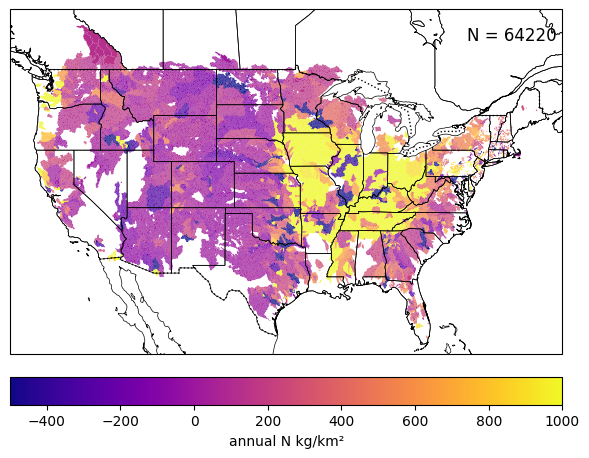

In [15]:
# Set up the figure and axis with a Cartopy projection
plt.figure(figsize=(6, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add basemap features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

final_gdf.plot(
    column=response_col,
    cmap='plasma',
    legend=True,
    edgecolor=None,
    vmax=1000,
    vmin=-500,
    legend_kwds={'label': "annual N kg/km²", 'orientation': "horizontal", 'pad': 0.05},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

plt.annotate(
    f"N = {len(final_gdf)}",
    xy=(0.99, 0.95),
    xycoords='axes fraction',
    ha='right',
    va='top',
    fontsize=12,
)

plt.tight_layout()
plt.savefig(VISUALS_DIR / "nitrogen_yield_map.png", dpi=600)


#### Final check for collinearity

Top 5 correlated feature pairs:
• Topographic Diversity & Slope: 0.9834
• Developed, Medium Intensity (%) & Developed, High Intensity (%): 0.8390
• Corn (%) & Soybeans (%): 0.8258
• Developed, Low Intensity (%) & Developed, Medium Intensity (%): 0.7421
• Developed, Low Intensity (%) & Developed, High Intensity (%): 0.6687


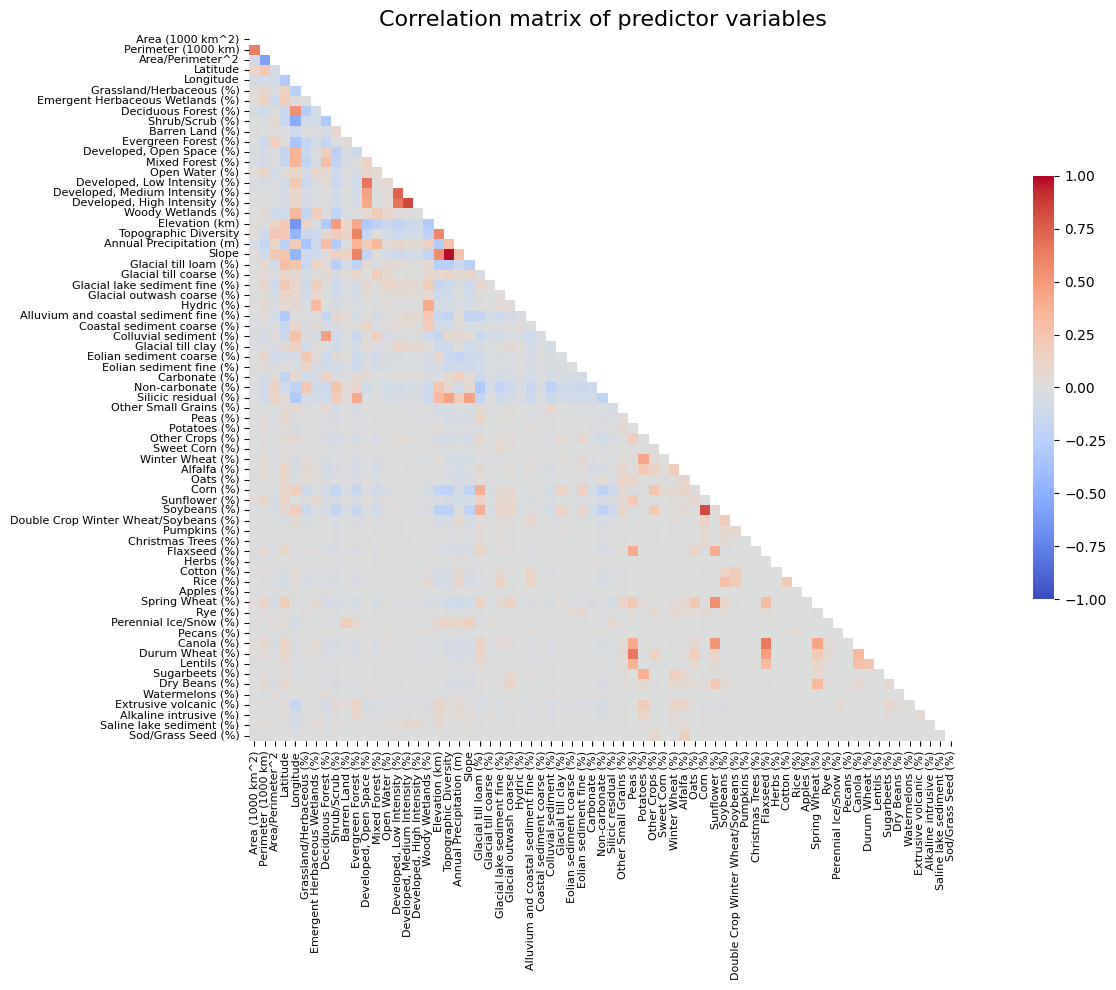

In [17]:
import seaborn as sns
import pandas as pd

cols_for_corr = [c for c in final_gdf.columns if not "Interaction" in c and "Indicator" not in c and c in predictor_cols]

X_for_corr_mapping = final_gdf[cols_for_corr].fillna(0)

corr_matrix = np.corrcoef(X_for_corr_mapping, rowvar=False)

# Create a DataFrame for the correlation matrix
corr_df = pd.DataFrame(corr_matrix, index=cols_for_corr, columns=cols_for_corr)

# Mask the lower triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Plot the heatmap with larger figure size
plt.figure(figsize=(16, 10))
sns.heatmap(corr_df, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, annot=False, 
            fmt=".2f", square=True, cbar_kws={"shrink": 0.6})
plt.title("Correlation matrix of predictor variables", fontsize=16)

# Ensure all ticks are visible
plt.xticks(np.arange(len(cols_for_corr)) + 0.5, cols_for_corr, rotation=90, fontsize=8)
plt.yticks(np.arange(len(cols_for_corr)) + 0.5, cols_for_corr, fontsize=8)

plt.tight_layout()
plt.savefig("visuals/correlation_matrix.png", dpi=300)

# Find the top 5 most correlated feature pairs
top_5_pairs = []
for i in range(len(cols_for_corr)):
    for j in range(i+1, len(cols_for_corr)):
        if abs(corr_matrix[i,j]) > 0.65:  # Only consider pairs with correlation > 0.65
            top_5_pairs.append((cols_for_corr[i], cols_for_corr[j], corr_matrix[i,j]))

# Sort and display top 5 correlated pairs
top_5_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
top_5_pairs = top_5_pairs[:5]  # Get top 5
print("Top 5 correlated feature pairs:")
for pair in top_5_pairs:
    print(f"• {pair[0]} & {pair[1]}: {pair[2]:.4f}")


### Extract per-catchment embeddings

#### Download embeddings from s3

In [18]:
import boto3
bucket_for_download = "vectorgeo"
prefix = "tmp"

# Download all parquet files from the s3 bucket
EMBED_DOWNLOAD_DIR = DATA_DIR / "embed"
os.makedirs(EMBED_DOWNLOAD_DIR, exist_ok=True)

s3 = boto3.client('s3')

parquet_files = s3.list_objects_v2(Bucket=bucket_for_download, Prefix=prefix)['Contents']
for file in parquet_files:
    file_key = file['Key']
    local_file_path = EMBED_DOWNLOAD_DIR / os.path.basename(file_key)

    if file_key.endswith(".parquet") and "vector-upload-lcd" in file_key and not os.path.exists(local_file_path):
        s3.download_file(bucket_for_download, file_key, str(local_file_path))
        print(f"Downloaded {file_key} to {local_file_path}")

In [19]:
# Read every parquet file in the directory and concatenate them
import os
import pandas as pd
import glob

embeddings_path = os.path.join(EMBED_DOWNLOAD_DIR, "vector-upload-lcd*.parquet")
embeddings_path = sorted(glob.glob(embeddings_path))

embed_dfs = []

bbox = merged_gdf.total_bounds
lat_min, lat_max = bbox[1], bbox[3]
lon_min, lon_max = bbox[0], bbox[2]

for path in embeddings_path:
    df = pd.read_parquet(path)

    # Embedding dataframe has lat and lon columns; this dataset has global
    # extent so we start by only taking those values within the bbox of
    # the catchments

    # Filter the DataFrame based on the bounding box
    df_filtered = df[(df['lat'] >= lat_min) & (df['lat'] <= lat_max) &
                        (df['lng'] >= lon_min) & (df['lng'] <= lon_max)]

    # Append the filtered DataFrame to the list
    embed_dfs.append(df_filtered)

embed_df = pd.concat(embed_dfs, ignore_index=True) if embed_dfs else pd.DataFrame()
print(f"Loaded embedding file with {len(embed_df)} rows and {len(embed_df.columns)} columns")

# Our next step is to identify, for each catchments, the embedding vectors which
# lie within the catchment. We'll convert the embed_df to a geodataframe with the lat/lng values
# then do an overlay
embed_gdf = gpd.GeoDataFrame(
    data=embed_df, 
    geometry=gpd.points_from_xy(embed_df.lng.values, embed_df.lat.values),
    crs=GEO_CRS
)
final_gdf['huc12'] = final_gdf.index.values
overlay_df = gpd.overlay(final_gdf, embed_gdf, how='intersection', keep_geom_type=False)

# Group by huc12 then take the average of the embedding vectors
# stored in the `embedding` column
# after first converting from list to numpy array
overlay_df['vector'] = overlay_df['vector'].apply(lambda x: np.array(x))
grouped_df = overlay_df.groupby('huc12').agg({
    'vector': lambda x: np.mean(np.vstack(x), axis=0),
    'geometry': 'first'
}).reset_index()

Z = np.vstack(grouped_df['vector'].values)
assert np.all(np.isfinite(Z)), "Z contains non-finite values"
print(f"Min and max values of Z: {np.min(Z)}, {np.max(Z)}")

Loaded embedding file with 2024920 rows and 4 columns
Min and max values of Z: -0.6989827454090118, 0.7868375709423652


### Save off arrays to S3


In [20]:
import os
import boto3
bucket_name = "duke-research"
bucket_prefix = ""
data_dir = "data"

os.makedirs(data_dir, exist_ok=True)

file_name_inputs = "inputs.npz"
file_name_gpkg = "final.gpkg"

gpkg_path = os.path.join(data_dir, file_name_gpkg)
inputs_path = os.path.join(data_dir, file_name_inputs)

if os.path.exists(gpkg_path):
    os.remove(gpkg_path)
    print(f"Deleted existing file: {gpkg_path}")

# GPKG doesn't support writing index + col 
# with the same name
final_gdf.drop("huc12", axis=1, errors='ignore') \
    .to_file(gpkg_path, driver="GPKG",overwrite=True)

if os.path.exists(inputs_path):
    os.remove(inputs_path)

np.savez(
    inputs_path,
    W_data=W.data,
    W_indices=W.indices,
    W_indptr=W.indptr,
    X=X,
    X_min=X_min,
    X_range=X_range,
    y=y,
    coords=coords,
    pretty_predictor_cols=pretty_predictor_cols,
    Z=Z
)

for fp in [gpkg_path, inputs_path]:
    file_name = os.path.basename(fp)
    s3_key = f"{bucket_prefix}{file_name}" if bucket_prefix else file_name
    print(f"Uploading {file_name} to s3://{bucket_name}/{s3_key}...")
    boto3.client('s3').upload_file(fp, bucket_name, s3_key)
    print(f"✓ Successfully uploaded {file_name}")

Deleted existing file: data/final.gpkg
Uploading final.gpkg to s3://duke-research/final.gpkg...
✓ Successfully uploaded final.gpkg
Uploading inputs.npz to s3://duke-research/inputs.npz...
✓ Successfully uploaded inputs.npz
